# Power Flow Example for the EHV and HV grids

This tutorial is a quick answer related to multiple more or less similar questions regarding "Making the complete SimBench grid run".

First of all, during the research project, most use cases were identified to be covered by power system data that models one or two voltage levels at the same time. Accordingly, the SimBench codes include those combinations of the base grids of SimBench (1 EHV grid, 2 HV grids, 4 MV grids, and 6 LV grids) which were expected most relevant for users' application. For reasons of completeness, the complete data sets "1-complete_data-mixed-all-0-sw" (no option to perform a proper power flow), "1-EHVHVMVLV-mixed-all-0-sw" (not tested for proper power flow results), and related data sets for futures scenarios 1 and 2 were provided, as well.

In contrast, this tutorial provides a simple example of a combined power flow for the German EHV and the two HV Grids provided by SimBench.

First get the SimBench grid of the code "1-EHVHV-mixed-all-0-no_sw".

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import pandapower as pp
import simbench as sb

net = sb.get_simbench_net("1-EHVHV-mixed-all-0-no_sw")

Note that the nuclear power units (which were active at the time of the project and are thus included in the scenario 0) were set as slack elements, i.e. in `pandapower` as external grid elements (`ext_grid`). For simplicity of the code, we replace these to `gen` elements.

On top of this, we need to assume some kind of simultaneity factor of the loads and sgens (`scaling`). Let's assume `0.35`. Accordingly, we adjust the active power of generators so that the total electric power consumption equals the total feed-in (we start with a DC power flow which disregards branch losses).

In [6]:
# --- convert ext_grids to gen elements and set some assumed active power setpoints
nuclear_gens = pp.toolbox.replace_ext_grid_by_gen(net, add_cols_to_keep=["slack_weight"])
net.gen.at[net.gen.index[-1], "slack"] = True
gens_with_p_2bset = pd.Index(nuclear_gens).difference([342])
net.gen.loc[gens_with_p_2bset, "p_mw"] = net.gen.loc[gens_with_p_2bset, "max_p_mw"]

# --- set scalings
scaling = {
    "load": 0.35,
    "sgen": 0.35,
}
gen_xg_scaling = ((net.load.p_mw *scaling["load"]).sum() - (net.sgen.p_mw *scaling["sgen"]).sum()) / (
    net.gen.p_mw.sum() + net.ext_grid.max_p_mw.sum())
scaling["gen"] = gen_xg_scaling

# --- apply the assumed and calculated scaling values
for et, scale in scaling.items():
    net[et]["scaling"] = scale

## DC Power Flow Results

In [7]:
# --- perform DC power flow
pp.rundcpp(net, distributed_slack=True)

# --- log some results
pp.toolbox.lf_info(net)

hp.pandapower.toolbox.result_info - INFO: Max voltage in vm_pu:
hp.pandapower.toolbox.result_info - INFO:   1.092 at busidx 0 (EHV Bus 1)
hp.pandapower.toolbox.result_info - INFO: Min voltage in vm_pu:
hp.pandapower.toolbox.result_info - INFO:   1.0 at busidx 3748 (HV2 Bus 361)
hp.pandapower.toolbox.result_info - INFO: Max loading trafo in %:
hp.pandapower.toolbox.result_info - INFO:   51.08204436767962 loading at trafo 34 (EHV Trafo 35)
hp.pandapower.toolbox.result_info - INFO:   51.08204436767962 loading at trafo 35 (EHV Trafo 36)
hp.pandapower.toolbox.result_info - INFO: Max loading line in %:
hp.pandapower.toolbox.result_info - INFO:   92.73344755050144 loading at line 824 (EHV Line 825)
hp.pandapower.toolbox.result_info - INFO:   85.93217745798063 loading at line 768 (EHV Line 769)


The log shows that the DC power flow results of this simple example include no line or transformer overloadings (max. line loading is around 93 %).

## AC Power Flow Results

In addition to a realistic load case (here equal scaling factors are applied all over the grid), several adjustments for the volt-var control are required for realistic AC power flows.
Again, only tap controllers for EHV-HV transformers and a distributed slack (to balance the branch losses) are applied here.

In [8]:
ehv_hv_trafos = sb.voltlvl_idx(net, "trafo", [3], "lv_bus")
pp.control.ContinuousTapControl(net, ehv_hv_trafos, 1.0)
pp.runpp(net, run_control=True, distributed_slack=True)

After calculating the AC power flow, we can analyze the voltage range and branch with the highest loading, cf. log and plot. As expected, the loadings increase. However, even this very simple assumptions result in acceptable voltages and almost no branch overloadings.
In actual grid operations, security margins for n-1 security must be added, especially regarding the few highly loaded lines.

hp.pandapower.toolbox.result_info - INFO: Max voltage in vm_pu:
hp.pandapower.toolbox.result_info - INFO:   1.1070887174089667 at busidx 56 (EHV Bus 57)
hp.pandapower.toolbox.result_info - INFO: Min voltage in vm_pu:
hp.pandapower.toolbox.result_info - INFO:   0.9933431959987652 at busidx 3477 (HV2 Bus 90)
hp.pandapower.toolbox.result_info - INFO: Max loading trafo in %:
hp.pandapower.toolbox.result_info - INFO:   48.65530642371104 loading at trafo 34 (EHV Trafo 35)
hp.pandapower.toolbox.result_info - INFO:   48.65530642371104 loading at trafo 35 (EHV Trafo 36)
hp.pandapower.toolbox.result_info - INFO: Max loading line in %:
hp.pandapower.toolbox.result_info - INFO:   101.5984172475295 loading at line 768 (EHV Line 769)
hp.pandapower.toolbox.result_info - INFO:   91.14251627977873 loading at line 824 (EHV Line 825)


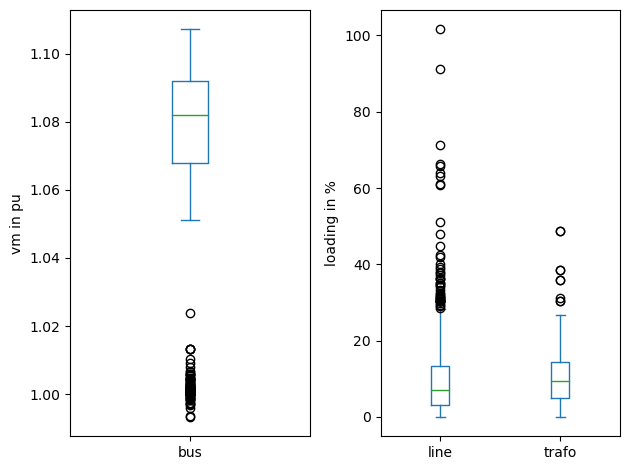

In [9]:
pp.lf_info(net)

# --- plot voltages and loadings of the AC power flow results
fig, axs = plt.subplots(ncols=2)
net.res_bus.vm_pu.rename("bus").plot(kind="box", ax=axs[0])
branch_loadings = pd.concat([
    net.res_line.loading_percent, net.res_trafo.loading_percent],
    axis=1, keys=["line", "trafo"])
branch_loadings.plot(kind="box", ax=axs[1])
axs[0].set_ylabel("vm in pu")
axs[1].set_ylabel("loading in %")
plt.tight_layout()